## Fisher forecasts - cosmological constrains

### Using the resdshift distributions of samples selected from the DES data

In this notebook I present forecasted cosmological constraints (confidence ellipses) obtained using samples selected from the third year of DES data.

I compare three samples:

- The redMaGiC sample. I use the same definition as the one in the candidacy paper
- A flux limited sample, with flux limit $i<22$.
- A sample where, on top of the above, I also impose the color cuts used in the BAO selection paper: $(i-z)+2(r-i)>1.7$.

I consider in all cases five bins between $z \in [0.2 - 0.95]$, without taking into account the cross-correlations between bins.

In [1]:
# Import stuff 
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from astropy.io import fits
from Ang_clust_SB_reddist import Fish_single_bin as FSB
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline
%pylab inline

plot_pretty()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import CosmicFish now
import math
import sys
import os
import IPython
#=================================================================================
cosmicfish_pylib_path = '/Users/Dimitris/Desktop/Candidacy_all/Theory/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))
#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Note: The function FSB that calculates the Fisher Matrix in a single bin is callable and takes as inputs:

FSB(z_mean, bias, n_z, dn_dDz, f_sky, N_gal)

- z_mean $\to$ the mean redshift of the bin

- bias $\to$ galaxy bias

- n_z $\to$ normalized redshift distribution

- dn_dDz $\to$ derivative w/r to shift of the redshift distributions

- f_sky $\to$ fraction of the sky the survey covers

- N_gal $\to$ number of galaxies in the bin

### Import and preprocess the data

### DES Flux limited and BAO-like samples

In [3]:
#Now the data
Y3 = fits.open('DES.fits')
z_mc = Y3[1].data['dnf_zmc_mof']
z_mean = Y3[1].data['dnf_zmean_mof']
z_sig = Y3[1].data['dnf_zsigma_mof']

i_auto = Y3[1].data['mag_auto_i']
g_auto = Y3[1].data['mag_auto_g']
r_auto = Y3[1].data['mag_auto_r']
z_auto = Y3[1].data['mag_auto_z']
spread_model_i = Y3[1].data['spread_model_i']
speraderr_model_i = Y3[1].data['spreaderr_model_i']

In [4]:
# Star - galaxy separation
star_gal = ((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)

# Define the color cuts now
col_cuts_1 = ((g_auto - r_auto)>-1.0)&((g_auto - r_auto)<3.0)
col_cuts_2 = ((r_auto - i_auto)>-1.0)&((r_auto - i_auto)<2.5)
col_cuts_3 = ((i_auto - z_auto)>-1.0)&((i_auto - z_auto)<2.0)
col_cuts = col_cuts_1&col_cuts_2&col_cuts_3

# Extra_cuts 
ex_cut = ((z_mean<1.5)&(z_mean>0.0)&(z_mc<1.5))

In [5]:
z_mc_1 = z_mc[star_gal&col_cuts&ex_cut]
z_mean_1 = z_mean[star_gal&col_cuts&ex_cut]
z_sig_1 = z_sig[star_gal&col_cuts&ex_cut]

i_auto_1 = i_auto[star_gal&col_cuts&ex_cut]
g_auto_1 = g_auto[star_gal&col_cuts&ex_cut]
r_auto_1 = r_auto[star_gal&col_cuts&ex_cut]
z_auto_1 = z_auto[star_gal&col_cuts&ex_cut] 

#### Bin the Flux-limited sample now

In [6]:
bin_1_FL = z_mc_1[(z_mean_1>0.20)&(z_mean_1<0.35)]
bin_2_FL = z_mc_1[(z_mean_1>0.35)&(z_mean_1<0.50)]
bin_3_FL = z_mc_1[(z_mean_1>0.50)&(z_mean_1<0.65)]
bin_4_FL = z_mc_1[(z_mean_1>0.65)&(z_mean_1<0.80)]
bin_5_FL = z_mc_1[(z_mean_1>0.80)&(z_mean_1<0.95)]

### BAO cuts and binning now

In [7]:
color_BAO_cut = (((i_auto_1 - z_auto_1)+2.0*(r_auto_1 - i_auto_1))>1.7)
mag_BAO_cut = (i_auto_1<(19.0+3.0*z_mean_1))
# ================================================================
z_mc_2 = z_mc_1[color_BAO_cut]#&mag_BAO_cut]
z_mean_2 = z_mean_1[color_BAO_cut]#&mag_BAO_cut]
z_sig_2 = z_sig_1[color_BAO_cut]#&mag_BAO_cut]

In [8]:
bin_1_BAO = z_mc_2[(z_mean_2>0.20)&(z_mean_2<0.35)]
bin_2_BAO = z_mc_2[(z_mean_2>0.35)&(z_mean_2<0.50)]
bin_3_BAO = z_mc_2[(z_mean_2>0.50)&(z_mean_2<0.65)]
bin_4_BAO = z_mc_2[(z_mean_2>0.65)&(z_mean_2<0.80)]
bin_5_BAO = z_mc_2[(z_mean_2>0.80)&(z_mean_2<0.95)]

### redMaGiC sample

In [9]:
RED_1 = fits.open('Redmagic_highdens_0.5_10.fit')
RED_2 = fits.open('Redmagic_highlum_1.0-04.fit')
RED_3 = fits.open('Redmagic_higherlum_1.5-01.fit')

In [10]:
red_photo_z_1  = RED_1[1].data['ZREDMAGIC']
red_error_z_1 = RED_1[1].data['ZREDMAGIC_E']
#============================================
red_photo_z_2  = RED_2[1].data['ZREDMAGIC']
red_error_z_2 = RED_2[1].data['ZREDMAGIC_E']
#============================================
red_photo_z_3  = RED_3[1].data['ZREDMAGIC']
red_error_z_3 = RED_3[1].data['ZREDMAGIC_E']

In [11]:
from numpy.random import normal as gauss
true_z_1 = gauss(red_photo_z_1,red_error_z_1)
true_z_2 = gauss(red_photo_z_2,red_error_z_2)
true_z_3 = gauss(red_photo_z_3,red_error_z_3)

In [12]:
bin_1_rm = true_z_1[(red_photo_z_1>0.20)&(red_photo_z_1<0.35)] 
bin_2_rm = true_z_1[(red_photo_z_1>0.35)&(red_photo_z_1<0.50)]
bin_3_rm = true_z_1[(red_photo_z_1>0.50)&(red_photo_z_1<0.65)]
bin_4_rm = true_z_2[(red_photo_z_2>0.65)&(red_photo_z_2<0.80)]
bin_5_rm = true_z_3[(red_photo_z_3>0.80)&(red_photo_z_3<0.95)]

In [13]:
import scipy.stats as stats 
f_sky = 4580.0/41253.0
nz = 10000 #number of steps to use for the radial/redshift integration
zarray = np.linspace(0,4.0,nz)
z = zarray[1:-1]

#### Calculation of the free (no priors) Fisher matrices

Bias model assummed $b(z) = 1 + \bar{z}$


##### Flux limited sample

In [14]:
from scipy.interpolate import UnivariateSpline as spl

In [15]:
# Initialize matrix
Fisher_FL_free = np.zeros([3,3])
for k in range(0,5):
    if (k==0):
        bin_z = bin_1_FL
    elif (k==1):
        bin_z = bin_2_FL
    elif (k==2):
        bin_z = bin_3_FL
    elif (k==3):
        bin_z = bin_4_FL
    else:
        bin_z = bin_5_FL
    
    # Simple calculations
    mean_z = np.mean(bin_z)
    N_gal = 32.0*np.float(len(bin_z))
    bias = 1.0 + mean_z
    # ==========================================================
    # ==========================================================
    # take a histogram for the redshift distribution 
    y_like, x_like = np.histogram(bin_z, bins=200, density=True) 
    x_like = x_like[:-1]
            
    bin_sp = spl(x_like,y_like,s=0.0, ext=1)     #Interpolate 
    
    Dz = 0.0 # This can change 
    n_z = bin_sp(z - Dz)   # this is the normalized n(z) in the range (0.0,4.0)
    
    # Calculate the derivative now 
    der_spl = bin_sp.derivative()
    dn_dDz = -der_spl(z)
    #Dz_up = Dz + 0.01
    #Dz_down = Dz - 0.01
    
    #n_z_up = bin_sp(z - Dz_up);n_z_down = bin_sp(z - Dz_down)
    #dn_dDz = (n_z_up - n_z_down)/(Dz_up - Dz_down)
    
    Fisher_FL_free += FSB(mean_z, bias, n_z, dn_dDz, f_sky, N_gal)

### BAO like sample

In [16]:
Fisher_BAO_free = np.zeros([3,3])
for k in range(0,5):
    if (k==0):
        bin_z = bin_1_BAO
    elif (k==1):
        bin_z = bin_2_BAO
    elif (k==2):
        bin_z = bin_3_BAO
    elif (k==3):
        bin_z = bin_4_BAO
    else:
        bin_z = bin_5_BAO
    
    # Simple calculations
    mean_z = np.mean(bin_z)
    N_gal = 32.0*np.float(len(bin_z))
    bias = 1.0 + mean_z
    # ==========================================================
    # ==========================================================
    # take a histogram for the redshift distribution 
    y_like, x_like = np.histogram(bin_z, bins=200, density=True) 
    x_like = x_like[:-1]
            
    bin_sp = spl(x_like,y_like, s=0.0, ext=1)     #Interpolate 
    
    Dz = 0.0 # This can change 
    n_z = bin_sp(z - Dz)   # this is the normalized n(z) in the range (0.0,4.0)

    # Calculate the derivative now 
    der_spl = bin_sp.derivative()
    dn_dDz = -der_spl(z)
    #Dz_up = Dz + 0.001
    #Dz_down = Dz - 0.001
    
    #n_z_up = bin_sp(z - Dz_up);n_z_down = bin_sp(z - Dz_down)
    #dn_dDz = (n_z_up - n_z_down)/(Dz_up - Dz_down)
    
    Fisher_BAO_free += FSB(mean_z, bias, n_z, dn_dDz, f_sky, N_gal)

### redMaGiC sample

In [17]:
Fisher_RM_free = np.zeros([3,3])
for k in range(0,5):
    if (k==0):
        bin_z = bin_1_rm
    elif (k==1):
        bin_z = bin_2_rm
    elif (k==2):
        bin_z = bin_3_rm
    elif (k==3):
        bin_z = bin_4_rm
    else:
        bin_z = bin_5_rm
    
    # Simple calculations
    mean_z = np.mean(bin_z)
    N_gal = np.float(len(bin_z))
    bias = 1.0 + mean_z
    # ==========================================================
    # ==========================================================
    # take a histogram for the redshift distribution 
    y_like, x_like = np.histogram(bin_z, bins=200, density=True) 
    x_like = x_like[:-1]
            
    bin_sp = spl(x_like,y_like, s=0.0, ext=1)     #Interpolate 
    
    Dz = 0.0 # This can change 
    n_z = bin_sp(z - Dz)   # this is the normalized n(z) in the range (0.0,4.0)

    # Calculate the derivative now
    der_spl = bin_sp.derivative()
    dn_dDz = -der_spl(z)
    
    #Dz_up = Dz + 0.01
    #Dz_down = Dz - 0.01
    #n_z_up = bin_sp(z - Dz_up);n_z_down = bin_sp(z - Dz_down)
    #dn_dDz = (n_z_up - n_z_down)/(Dz_up - Dz_down)
    Fisher_RM_free += FSB(mean_z, bias, n_z, dn_dDz, f_sky, N_gal)

### Add priors, marginalize

We have calculated the free Fisher matrices (which means, complete uncertainty in the value of $\Delta z$ per bin.

Now we are going to calculate the same things but adding some priors; we will marginalize over the redshift uncertainty and plot the forecasted constrains on the other two parameters.

In [18]:
from Tools import marginalize as marg

Let's first plot the marginalized posterior for the three samples defined and calculated above, without any prior.

In [19]:
Marg_FL_free = marg(Fisher_FL_free)
Marg_BAO_free = marg(Fisher_BAO_free)
Marg_RM_free = marg(Fisher_RM_free)

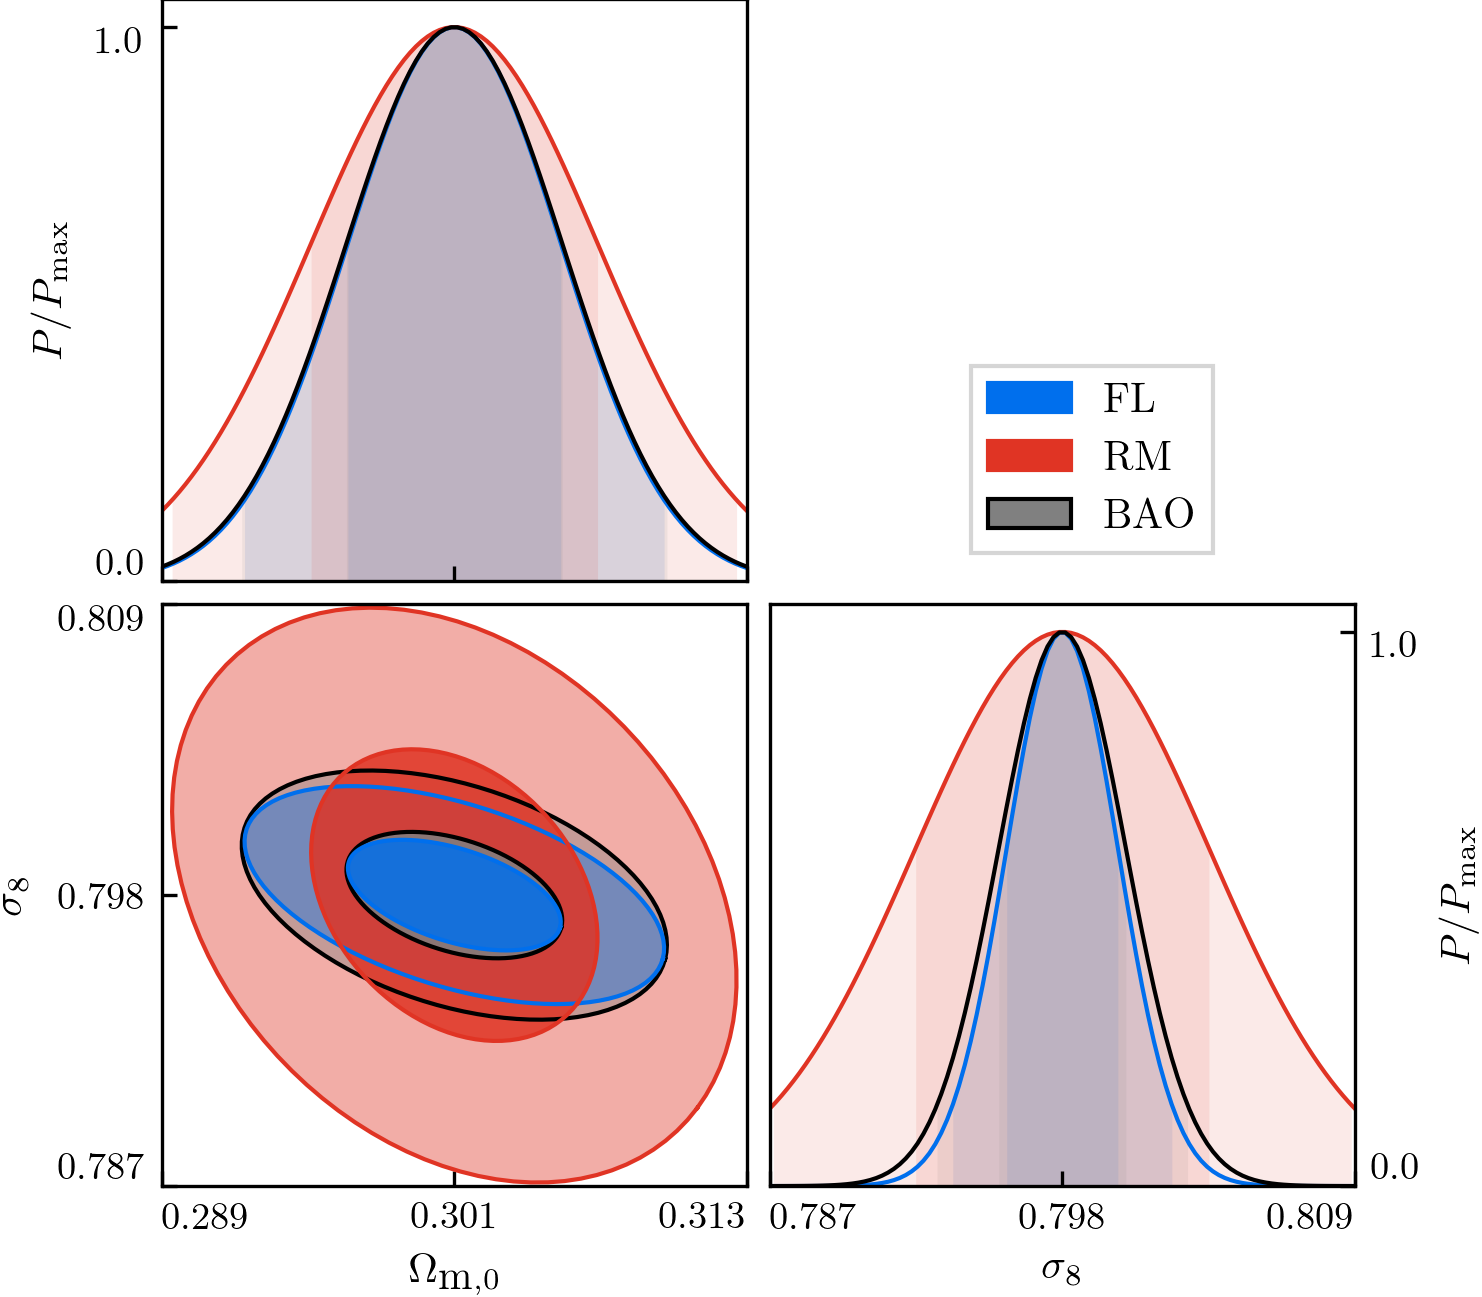

In [20]:
param_names = ['$\Omega_{\mbox{m},0}$', '$\sigma_8$']
fiducial = [0.301, 0.798]
matrix_1 = Marg_FL_free
matrix_2 = Marg_RM_free
matrix_3 = Marg_BAO_free

fisher_1 = fm.fisher_matrix( fisher_matrix=matrix_1, fiducial = fiducial, param_names=param_names )
fisher_2 = fm.fisher_matrix( fisher_matrix=matrix_2, fiducial = fiducial, param_names=param_names )
fisher_3 = fm.fisher_matrix( fisher_matrix=matrix_3, fiducial = fiducial, param_names=param_names )
fisher_1.name = 'FL'
fisher_2.name = 'RM'
fisher_3.name = 'BAO'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher_1,fisher_2, fisher_3])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('FL_and_RM.pdf', dpi=200)


In [21]:
from Tools import FoM_return as FoM

In [22]:
FoM_FL = FoM(Fisher_FL_free)
FoM_BAO = FoM(Fisher_BAO_free)
FoM_RM =  FoM(Fisher_RM_free)

Let's print the ratios of the Figures of Merit

In [23]:
print(FoM_FL/FoM_RM)

3.886777424864365


In [24]:
print(FoM_FL/FoM_BAO)

1.218522463024861


In [25]:
print(FoM_BAO/FoM_RM)

3.1897462236484553


Now let's add some reasonable priors and marginalize over them.

I addopt the following priors (common in all bins)

- For the flux limited sample $\sigma(\Delta z) = 0.015$

- For the redMaGiC sample $\sigma(\Delta z) = 0.007$

- For the BAO sample $\sigma(\Delta z) = 0.01$.

In [26]:
sigma_FL = 0.015
sigma_BAO = 0.01
sigma_RM = 0.007
# =========================================
# =========================================
prior_FL = 5.0/(sigma_FL**2.0)
prior_BAO = 5.0/(sigma_BAO**2.0)
prior_RM = 5.0/(sigma_RM**2.0)

In [28]:
# Add the priors now
Fisher_FL_prior = np.copy(Fisher_FL_free)
Fisher_FL_prior[2,2] = Fisher_FL_prior[2,2] + prior_FL

Fisher_BAO_prior = np.copy(Fisher_BAO_free)
Fisher_BAO_prior[2,2] = Fisher_BAO_prior[2,2] + prior_BAO

Fisher_RM_prior = np.copy(Fisher_RM_free)
Fisher_RM_prior[2,2] = Fisher_RM_prior[2,2] + prior_RM

In [30]:
# Marginalize 
FL_marg_prior = marg(Fisher_FL_prior)
BAO_marg_prior = marg(Fisher_BAO_prior)
RM_marg_prior = marg(Fisher_RM_prior)

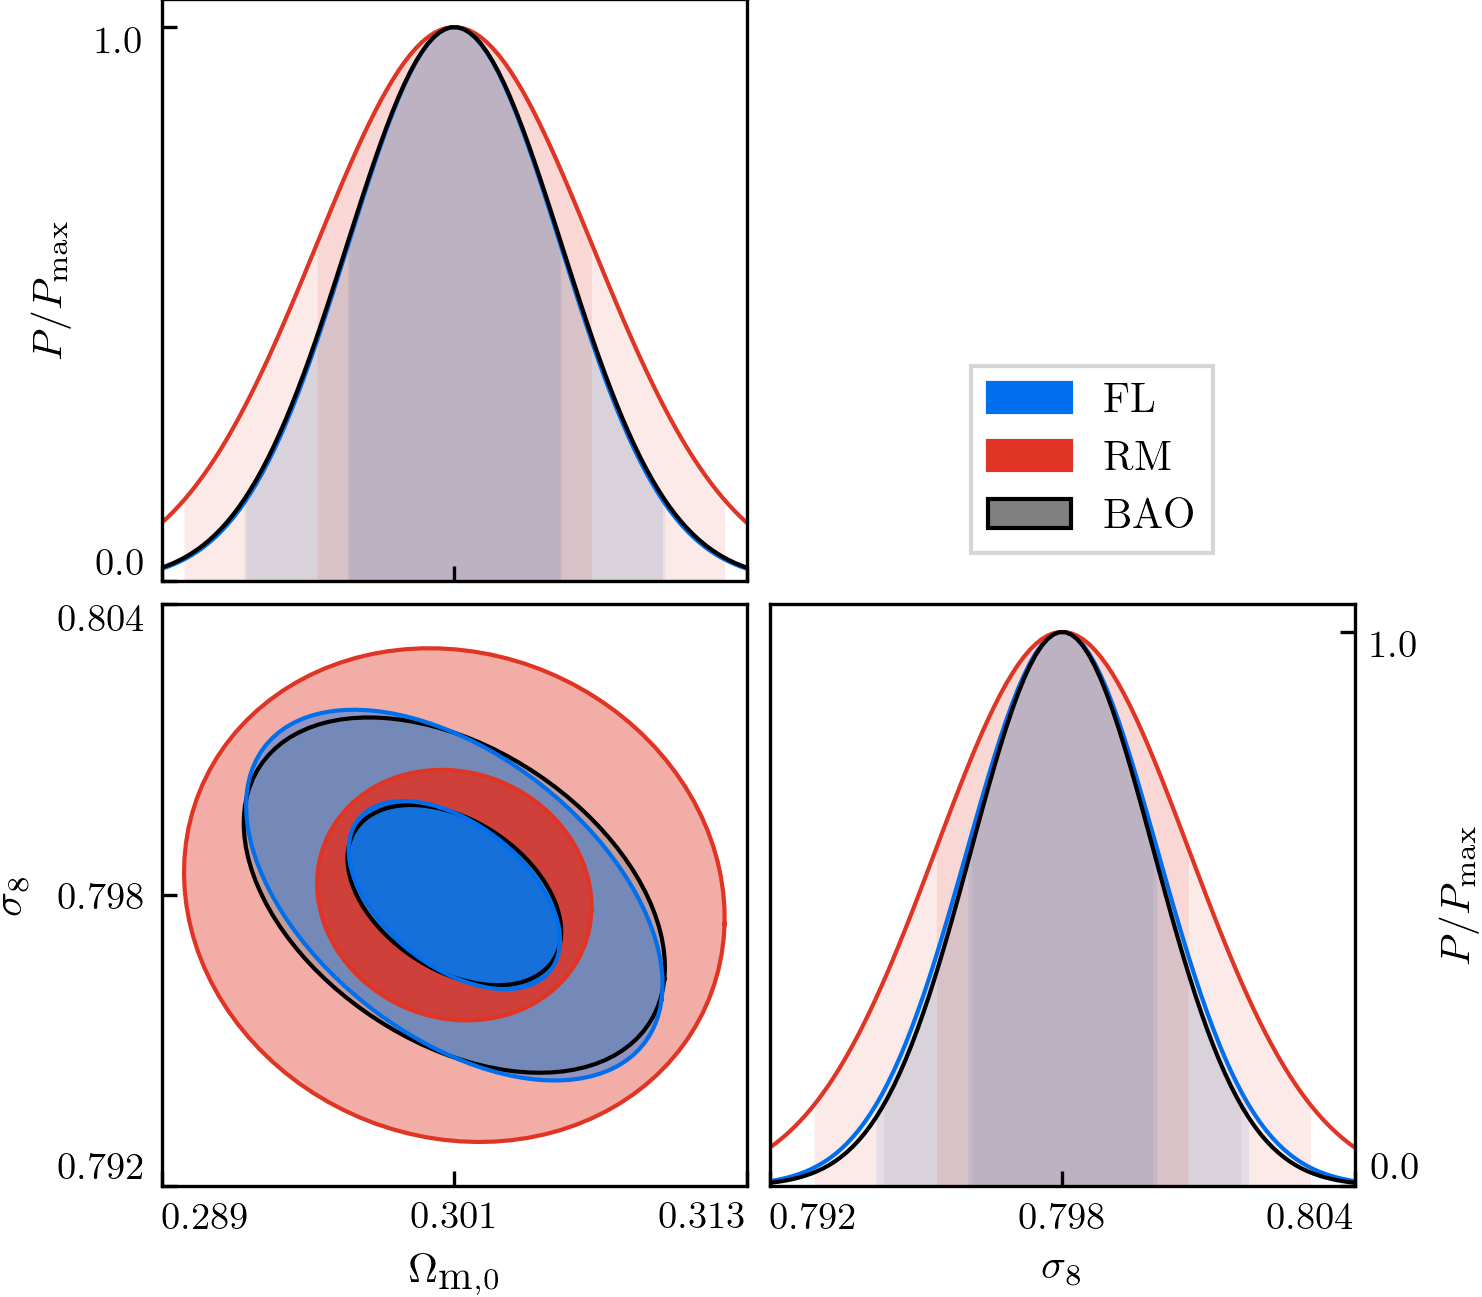

In [31]:
matrix_1 = FL_marg_prior
matrix_2 = RM_marg_prior
matrix_3 = BAO_marg_prior

fisher_1 = fm.fisher_matrix( fisher_matrix=matrix_1, fiducial = fiducial, param_names=param_names )
fisher_2 = fm.fisher_matrix( fisher_matrix=matrix_2, fiducial = fiducial, param_names=param_names )
fisher_3 = fm.fisher_matrix( fisher_matrix=matrix_3, fiducial = fiducial, param_names=param_names )
fisher_1.name = 'FL'
fisher_2.name = 'RM'
fisher_3.name = 'BAO'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher_1,fisher_2, fisher_3])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('FL_and_RM_priors.pdf', dpi=200)

